In [1]:
import scipy.io
import h5py
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import linregress
import pandas as pd
import pickle
from os import listdir
from os.path import isfile, join
from ll_xy import lonlat_to_xy
from netCDF4 import Dataset
import string
from scipy.spatial import KDTree
import itertools

### create dataframe with mooring data

In [2]:
datapath = '/Users/carmennab/cpom_server/home/cjn/alpha_retracker/data/monthly_SIT_products/'

mooring_dfs = {}

for mooring in ['a','b','d']:
    
    d = Dataset(f'{datapath}BGEP/ULS_SIT_{mooring.upper()}.nc')
    sit = np.array(d['Sea Ice Thickness'])
    days = np.array(d['Day'])
    dt0 = datetime.date(2010,1,1)
    dates = np.asarray([dt0 + datetime.timedelta(days=int(x)) for x in days])
    months = np.asarray([x.month for x in dates])
    years = np.asarray([x.year for x in dates])
    
    dfs = []
    
    for year in np.arange(2010,2022):
        
        df = pd.DataFrame({'SIT':sit[years==year],
                           'year':years[years==year],
                          'month':months[years==year],
                          'date':dates[years==year]})
        
        dfs.append(df)
        
        
    df = pd.concat(dfs)
    
    mooring_dfs[mooring] = df

In [3]:
yearlist = np.arange(2010,2022)
monthlist = ["01","02","03","04","10","11","12"]

colors = {'a':'#a6cee3',
          'b':'#1f78b4',
          'c':'orange',
          'd':'#33a02c'}

In [4]:
master_df = []

for mooring, df in mooring_dfs.items():

    years_active = set(df['year'])
    
    list_of_dicts = []    

    for year in np.arange(2010,2022):

        df_yr = df[df['year']==year]

        for month in monthlist:

            df_yr_mo = df_yr[df_yr['month']==int(month)]

            list_of_dicts.append({'year':year,'month':month,'SIT':np.nanmean(df_yr_mo['SIT'])})

    df_mo = pd.DataFrame(list_of_dicts).dropna()
    
    df_mo['mooring'] = mooring
    
    master_df.append(df_mo)

master_df = pd.concat(master_df).reset_index()

master_df

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_3433/1654530835.py:17: RuntimeWarning: Mean of empty slice
  list_of_dicts.append({'year':year,'month':month,'SIT':np.nanmean(df_yr_mo['SIT'])})
/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_3433/1654530835.py:17: RuntimeWarning: Mean of empty slice
  list_of_dicts.append({'year':year,'month':month,'SIT':np.nanmean(df_yr_mo['SIT'])})
/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_3433/1654530835.py:17: RuntimeWarning: Mean of empty slice
  list_of_dicts.append({'year':year,'month':month,'SIT':np.nanmean(df_yr_mo['SIT'])})


,index,year,month,SIT,mooring
0,4,2010,10,0.287956,a
1,5,2010,11,0.551501,a
2,6,2010,12,0.808255,a
3,7,2011,01,1.149679,a
4,8,2011,02,1.385042,a
...,...,...,...,...,...
226,76,2020,12,0.807308,d
227,77,2021,01,1.374948,d
228,78,2021,02,1.634491,d
229,79,2021,03,1.861981,d


### load mooring EASE locations and add to dataframe

In [8]:
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/sit/pysiral/'
ind2ds = pd.read_csv(datapath+'locs.csv') # load mooring ease locations

ind2ds.reset_index()

,index,year,month,mooring,lon,lat
0,0,2010,10,a,-149.97907,75.00092
1,1,2010,10,b,-149.96996,77.98854
2,2,2010,10,d,-139.98340,73.99908
3,3,2010,11,a,-149.97907,75.00092
4,4,2010,11,b,-149.96996,77.98854
...,...,...,...,...,...,...
425,425,2018,12,f14,-6.50100,78.81500
426,426,2019,1,f14,-6.50100,78.81500
427,427,2019,2,f14,-6.50100,78.81500
428,428,2019,3,f14,-6.50100,78.81500


In [ ]:
lons = []
lats = []

for year,month,mooring in zip(master_df['year'],master_df['month'],master_df['mooring']):
    data = ind2ds[(ind2ds['year']==year) & (ind2ds['month']==int(month)) & (ind2ds['mooring']==mooring)]
    if len(data)>0:
        lons.append(data['lon'].iloc[0])
        lats.append(data['lat'].iloc[0])
    else:
        lons.append(np.nan)
        lats.append(np.nan)
        
master_df['mooring_lon'] = lons
master_df['mooring_lat'] = lats

In [10]:
master_df

,index,year,month,SIT,mooring
0,4,2010,10,0.287956,a
1,5,2010,11,0.551501,a
2,6,2010,12,0.808255,a
3,7,2011,01,1.149679,a
4,8,2011,02,1.385042,a
...,...,...,...,...,...
226,76,2020,12,0.807308,d
227,77,2021,01,1.374948,d
228,78,2021,02,1.634491,d
229,79,2021,03,1.861981,d


### get data from each SIT product in mooring grid cells and add to dataframe

In [38]:
radii = [25_000,50_000,100_000]

In [ ]:
# AWI

datapath = '/Users/carmennab/cpom_server/home/cjn/alpha_retracker/data/monthly_SIT_products/'

d = Dataset(datapath+'AWI_CS2/201202.nc')
e2_lon = np.array(d['lon'])
e2_lat = np.array(d['lat'])

e2_x, e2_y = lonlat_to_xy(e2_lon,e2_lat,hemisphere='n')

tree = KDTree(list(zip(e2_x.ravel(),e2_y.ravel())))

awi_e2_inds = {}

years = np.arange(2010,2022)
    
for year in years:
    awi_e2_inds[year] = {}
    for mooring in ['a','b','d']:
        
        mooring_lon,mooring_lat = master_df[['mooring_lon','mooring_lat']][master_df['year']==year].iloc[0]
        
        x,y = lonlat_to_xy(np.array(mooring_lon),np.array(mooring_lat),hemisphere='n')

        dist, ind = tree.query([x,y])

        ind2d = np.unravel_index(ind, (432,432))

        radius_inds = {}

        for radius in radii:
            inds = tree.query_ball_point([x,y],r=radius)
            radius_inds[radius] = [np.unravel_index(ind, (432,432)) for ind in inds]

        awi_e2_inds[year][mooring] = {'0':[ind2d]}

        for r in radii:    
            awi_e2_inds[year][mooring][str(r)[:-3]] = radius_inds[r]
            
#awi_e2_inds

In [ ]:
d = Dataset(datapath+'NSIDC/RDEFT4_20101114.nc')
e2_lon = np.array(d['lon'])
e2_lat = np.array(d['lat'])

e2_x, e2_y = lonlat_to_xy(e2_lon,e2_lat,hemisphere='n')

tree = KDTree(list(zip(e2_x.ravel(),e2_y.ravel())))

nsidc_e2_inds = {}

years = np.arange(2010,2022)
    
for year in years:
    nsidc_e2_inds[year] = {}
    for mooring in ['a','b','d']:
        
        mooring_lon,mooring_lat = master_df[['mooring_lon','mooring_lat']][master_df['year']==year].iloc[0]
        
        x,y = lonlat_to_xy(np.array(mooring_lon),np.array(mooring_lat),hemisphere='n')

        dist, ind = tree.query([x,y])

        ind2d = np.unravel_index(ind, (448,304))

        radius_inds = {}

        for radius in radii:
            inds = tree.query_ball_point([x,y],r=radius)
            radius_inds[radius] = [np.unravel_index(ind, (448,304)) for ind in inds]


        nsidc_e2_inds[year][mooring] = {'0':[ind2d]}

        for r in radii: 
            nsidc_e2_inds[year][mooring][str(r)[:-3]] = radius_inds[r]

#nsidc_e2_inds

In [ ]:
df = pd.read_csv(datapath+'CPOM_CS2/201103.txt',sep = ' ')
cpom_lat = np.array(df.iloc[:,0])
cpom_lon = np.array(df.iloc[:,1])

cpom_longrid = np.reshape(cpom_lon, (1335, 1335))
cpom_latgrid = np.reshape(cpom_lat, (1335, 1335))

e2_x, e2_y = lonlat_to_xy(cpom_longrid,cpom_latgrid,hemisphere='n')

tree = KDTree(list(zip(e2_x.ravel(),e2_y.ravel())))

cpom_e2_inds = {}

years = np.arange(2010,2022)
    
for year in years:
    cpom_e2_inds[year] = {}
    for mooring in ['a','b','d']:
        
        mooring_lon,mooring_lat = master_df[['mooring_lon','mooring_lat']][master_df['year']==year].iloc[0]
        
        x,y = lonlat_to_xy(np.array(mooring_lon),np.array(mooring_lat),hemisphere='n')

        dist, ind = tree.query([x,y])

        ind2d = np.unravel_index(ind, (1335,1335))

        radius_inds = {}

        for radius in radii:
            inds = tree.query_ball_point([x,y],r=radius)
            radius_inds[radius] = [np.unravel_index(ind, (1335,1335)) for ind in inds]

        cpom_e2_inds[year][mooring] = {'0':[ind2d]}

        for r in radii: 
            cpom_e2_inds[year][mooring][str(r)[:-3]] = radius_inds[r]

#cpom_e2_inds

In [42]:
mooring_inds = {'cpom':cpom_e2_inds,
            'awi':awi_e2_inds,
            'nsidc':nsidc_e2_inds}

In [ ]:
#mooring_inds

### calculate mean monthly SIT within radius of moorings

In [44]:
datapath = '/Users/carmennab/cpom_server/home/cjn/alpha_retracker/data/monthly_SIT_products/'
sit_dict = pickle.load(open(datapath+'sits.p','rb')) # open pickle file created in process_SIT_products.ipynb

In [ ]:
#sit_dict

In [46]:
for r in [0]+radii:

    mooring_sits = {s:[] for s in mooring_inds.keys()}

    for month, year, mooring in zip(master_df['month'],master_df['year'],master_df['mooring']):

        for product in mooring_sits.keys():
            
            try:

                sit = sit_dict[product][year][month]

                mooring_inds_rad = mooring_inds[product][year][mooring][str(int(r/1000))]


                sit_inds = [sit[mooring_ind] for mooring_ind in mooring_inds_rad]

                mooring_sits[product].append(np.nanmean(sit_inds))
            
            except: 
                mooring_sits[product].append(np.nan)

    for product in mooring_sits.keys():
        master_df[f'{product.upper()}_SIT_{r}'] = mooring_sits[product]

master_df

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_3433/730228613.py:18: RuntimeWarning: Mean of empty slice
  mooring_sits[product].append(np.nanmean(sit_inds))
/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_3433/730228613.py:18: RuntimeWarning: Mean of empty slice
  mooring_sits[product].append(np.nanmean(sit_inds))


,index,year,month,SIT,mooring,mooring_lon,mooring_lat,CPOM_SIT_0,AWI_SIT_0,NSIDC_SIT_0,...,CPOM_SIT_250000_c,AWI_SIT_500000_c,NSIDC_SIT_500000_c,CPOM_SIT_500000_c,AWI_SIT_1000000_c,NSIDC_SIT_1000000_c,CPOM_SIT_1000000_c,CPOM_SIT_25000,AWI_SIT_25000,NSIDC_SIT_25000
0,4,2010,10,0.287956,a,-149.97907,75.00092,NaN,0.591535,0.922375,...,0.490321,0.687478,1.203992,0.504687,0.989275,1.501323,0.536046,NaN,0.536042,0.901973
1,5,2010,11,0.551501,a,-149.97907,75.00092,0.6160,0.667980,0.944956,...,0.999410,0.771005,1.266899,0.974417,1.067490,1.534029,0.848573,0.689303,0.671500,0.935630
2,6,2010,12,0.808255,a,-149.97907,75.00092,0.8401,0.657750,0.944956,...,1.133641,0.917303,1.375527,1.194004,1.173798,1.607174,1.046983,0.864740,0.713975,0.935630
3,7,2011,01,1.149679,a,-149.97907,75.00092,0.7761,0.842873,1.240129,...,1.284588,1.093450,1.591532,1.363265,1.346786,1.818057,1.205602,0.801610,0.821311,1.337781
4,8,2011,02,1.385042,a,-149.97907,75.00092,1.3329,1.323346,1.537661,...,1.453667,1.339173,1.832984,1.540317,1.585680,2.025997,1.362529,1.246540,1.230019,1.521213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,76,2020,12,0.807308,d,-140.04011,73.98906,0.9822,0.790808,1.220503,...,1.133641,0.917303,1.375527,1.194004,1.173798,1.607174,1.046983,1.060250,0.808822,1.180318
227,77,2021,01,1.374948,d,-140.04011,73.98906,NaN,NaN,1.156160,...,1.284588,1.093450,1.591532,1.363265,1.346786,1.818057,1.205602,NaN,NaN,1.345371
228,78,2021,02,1.634491,d,-140.04011,73.98906,NaN,NaN,1.649230,...,1.453667,1.339173,1.832984,1.540317,1.585680,2.025997,1.362529,NaN,NaN,1.630442
229,79,2021,03,1.861981,d,-140.04011,73.98906,NaN,NaN,1.718863,...,1.702848,1.603019,1.944260,1.776897,1.829774,2.112130,1.535778,NaN,NaN,1.701885


In [47]:
for r in [0] + radii:
    
    print(f'Radius: {r}')

    products = ['AWI_SIT','NSIDC_SIT','CPOM_SIT']

    pclims = []

    for month, mooring in itertools.product(monthlist,['a','b','d']):

        cd = master_df[(master_df['month']==month) & (master_df['mooring']==mooring)]

        for product in products:

            nm = np.nanmean(cd[f'{product}_{r}'])

            pclims.append( {'product':product,'month':month,'mooring':mooring,'SIT':nm} )

    df = pd.DataFrame(pclims)

    pclims = {p:[] for p in products}

    for month, mooring in zip(master_df['month'],master_df['mooring']):

        for product in products:

            val  = float(df[(df['product']==product)&(df['mooring']==mooring)&(df['month']==month)]['SIT'])

            pclims[product].append(val)

    for p in products:

        master_df[p+f'_{r}'+'_c'] = pclims[p]

Radius: 0
Radius: 25000
Radius: 50000
Radius: 100000


### create figure for all months combined

In [48]:
datapath_out = '/Users/carmennab/Dropbox/Apps/Overleaf/Alpha Retracker/'

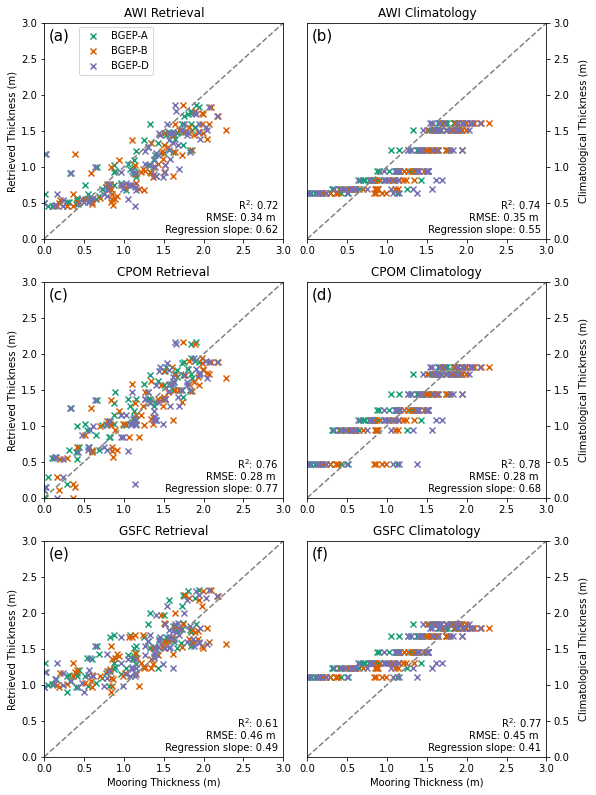

In [49]:
colors = {'a':'#1b9e77',
          'b':'#d95f02',
          'd':'#7570b3'}

fs = 10

for r in [100_000]:

    fig, axs = plt.subplots(3,2,figsize=(9,12*(9/8)))

    for var,label,(ax1,ax2) in zip([f'AWI_SIT_{r}',f'CPOM_SIT_{r}',f'NSIDC_SIT_{r}'],
                            ['AWI','CPOM','GSFC'],
                            axs):

        for mooring in ['a','b','d']:
            df = master_df[master_df['mooring']==mooring]

            ax1.scatter(df['SIT'],df[var],color=colors[mooring],label=f'BGEP-{mooring.upper()}',marker='x')

            ax2.scatter(df['SIT'],df[f'{var}_c'],color=colors[mooring],label=f'BGEP-{mooring.upper()}',marker='x')

        for ax, c in zip((ax1,ax2),['','_c']):
            ax.set_ylim(-0.1,3)
            ax.set_xlim(-0.1,3)
            ax.plot([0,3],[0,3],color='grey',linestyle='dashed')    

            if 'GSFC' == label:
                ax.set_xlabel('Mooring Thickness (m)',fontsize=10)

            df = master_df[['SIT',var+c]].copy()
 
            rmse = np.sqrt(np.nanmean(np.square(df[var+c]-df['SIT'])))

            lr = linregress(df['SIT'][~np.isnan(df[var+c])],df[var+c][~np.isnan(df[var+c])])
            corr = lr[2]

            slope = np.round(lr[0],decimals=2)
            r2 = np.round(corr**2,decimals=2)
            rmse_str = np.round(rmse,decimals=2)
            
#             line = lr[0] * df['SIT'] + lr[1]
#             print(np.nanmin(df[var+c]),np.nanmax(df[var+c]))
#             ax.plot(df['SIT'],line,color='black',linestyle=':',zorder=10000) 

            ax.annotate(f'R$^2$: {r2}\nRMSE: {rmse_str} m \n Regression slope: {slope}',xy=(0.98,0.02),
                        xycoords='axes fraction',va='bottom',ha='right',fontsize=fs)


        ax1.set_ylabel('Retrieved Thickness (m)',fontsize=fs)
        ax2.set_ylabel('Climatological Thickness (m)',fontsize=fs,labelpad=10)

        ax1.set_title(f'{label} Retrieval',fontsize=fs+2)
        ax2.set_title(f'{label} Climatology',fontsize=fs+2)

        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position('right')
        
        for ax in (ax1,ax2):
            ax.set_xlim(0,3)
            ax.set_ylim(0,3)

    axs.reshape(-1)[0].legend(bbox_to_anchor=(0.3,0.87),loc='center',fontsize=fs)
    fig.subplots_adjust(hspace=0.2,wspace=0.1)
    
    for letter, ax in zip(string.ascii_lowercase, axs.reshape(-1)):
        ax.annotate(f'({letter})',xycoords='axes fraction',fontsize=fs+5,xy=(0.02,0.92))
    
#     plt.savefig(datapath_out+'main_figs/climatology.png',bbox_inches='tight',dpi=500)
    
    plt.show()
    

### create figures with different radii for supplement

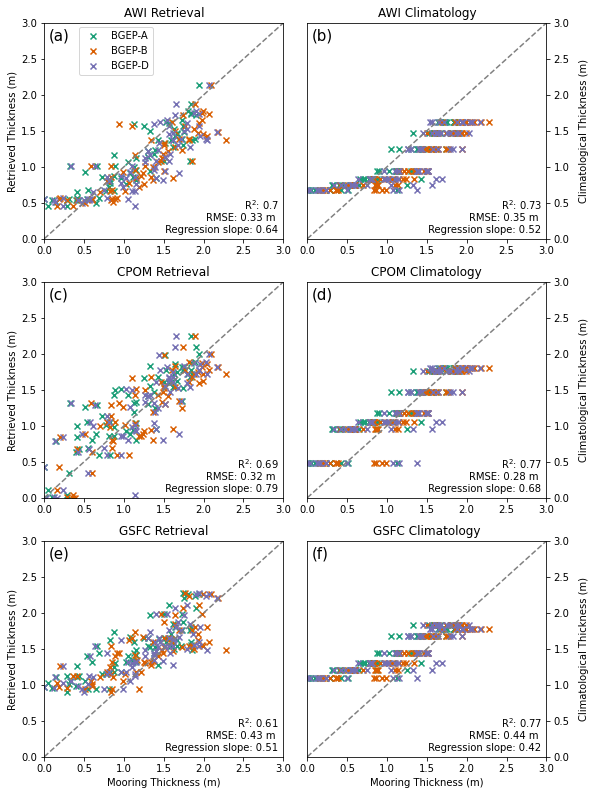

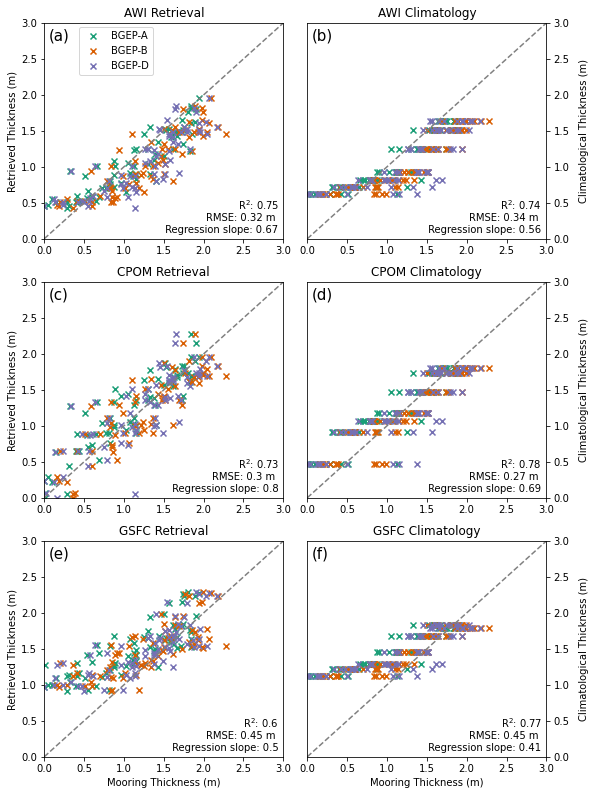

In [50]:
colors = {'a':'#1b9e77',
          'b':'#d95f02',
          'd':'#7570b3'}

fs = 10

for r,name in zip([25_000,50_000],['25km','50km']):

    fig, axs = plt.subplots(3,2,figsize=(9,12*(9/8)))

    for var,label,(ax1,ax2) in zip([f'AWI_SIT_{r}',f'CPOM_SIT_{r}',f'NSIDC_SIT_{r}'],
                            ['AWI','CPOM','GSFC'],
                            axs):

        for mooring in ['a','b','d']:
            df = master_df[master_df['mooring']==mooring]

            ax1.scatter(df['SIT'],df[var],color=colors[mooring],label=f'BGEP-{mooring.upper()}',marker='x')

            ax2.scatter(df['SIT'],df[f'{var}_c'],color=colors[mooring],label=f'BGEP-{mooring.upper()}',marker='x')

        for ax, c in zip((ax1,ax2),['','_c']):
            ax.set_ylim(-0.1,3)
            ax.set_xlim(-0.1,3)
            ax.plot([0,3],[0,3],color='grey',linestyle='dashed')    

            if 'GSFC' == label:
                ax.set_xlabel('Mooring Thickness (m)',fontsize=10)

            df = master_df[['SIT',var+c]].copy()
 
            rmse = np.sqrt(np.nanmean(np.square(df[var+c]-df['SIT'])))

            lr = linregress(df['SIT'][~np.isnan(df[var+c])],df[var+c][~np.isnan(df[var+c])])
            corr = lr[2]

            slope = np.round(lr[0],decimals=2)
            r2 = np.round(corr**2,decimals=2)
            rmse_str = np.round(rmse,decimals=2)
            
#             line = lr[0] * df['SIT'] + lr[1]
#             print(np.nanmin(df[var+c]),np.nanmax(df[var+c]))
#             ax.plot(df['SIT'],line,color='black',linestyle=':',zorder=10000) 

            ax.annotate(f'R$^2$: {r2}\nRMSE: {rmse_str} m \n Regression slope: {slope}',xy=(0.98,0.02),
                        xycoords='axes fraction',va='bottom',ha='right',fontsize=fs)


        ax1.set_ylabel('Retrieved Thickness (m)',fontsize=fs)
        ax2.set_ylabel('Climatological Thickness (m)',fontsize=fs,labelpad=10)

        ax1.set_title(f'{label} Retrieval',fontsize=fs+2)
        ax2.set_title(f'{label} Climatology',fontsize=fs+2)

        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position('right')
        
        for ax in (ax1,ax2):
            ax.set_xlim(0,3)
            ax.set_ylim(0,3)

    axs.reshape(-1)[0].legend(bbox_to_anchor=(0.3,0.87),loc='center',fontsize=fs)
    fig.subplots_adjust(hspace=0.2,wspace=0.1)
    
    for letter, ax in zip(string.ascii_lowercase, axs.reshape(-1)):
        ax.annotate(f'({letter})',xycoords='axes fraction',fontsize=fs+5,xy=(0.02,0.92))
    
    plt.savefig(f'{datapath_out}supp_figs/climatology_{name}.png',bbox_inches='tight',dpi=500)
    
    plt.show()
    

### create monthly figures for supplement


10


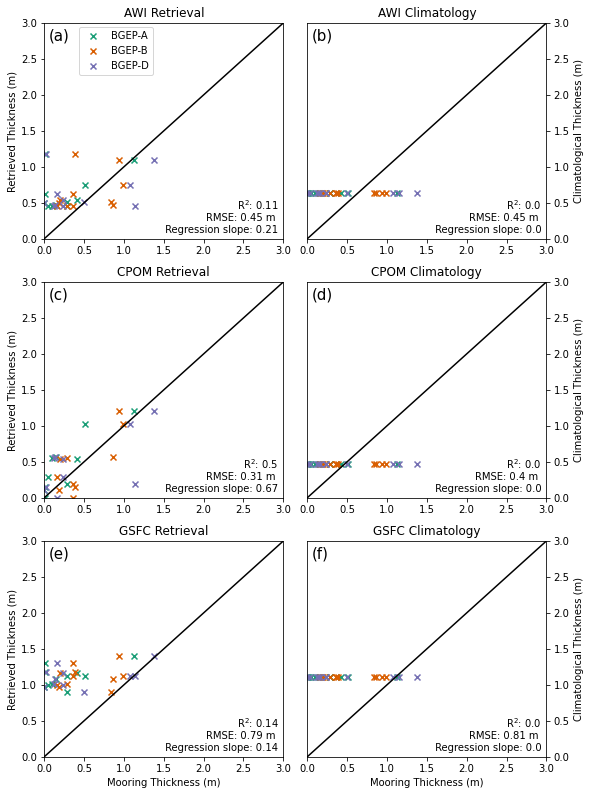


11


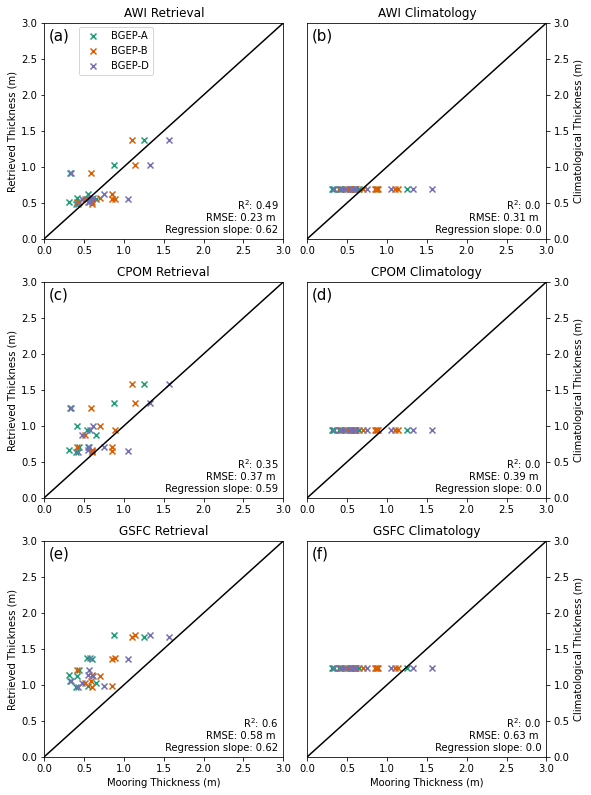


12


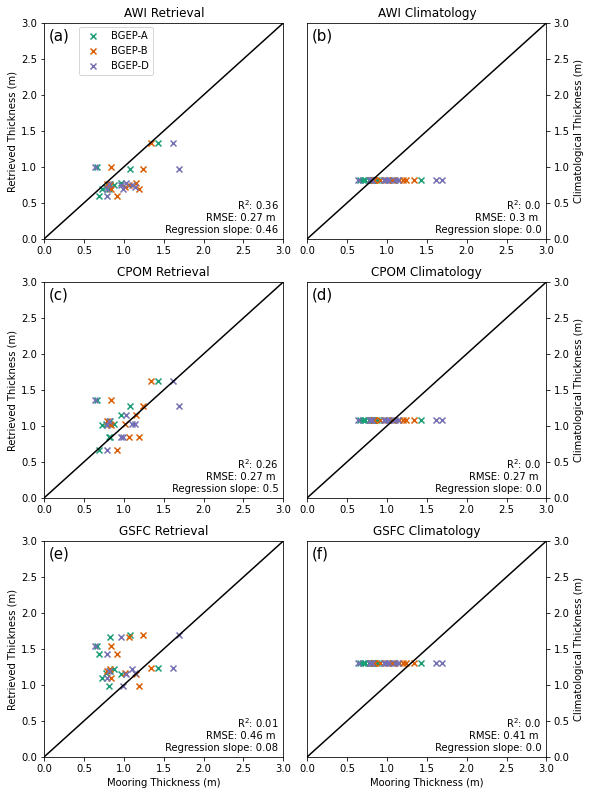


1


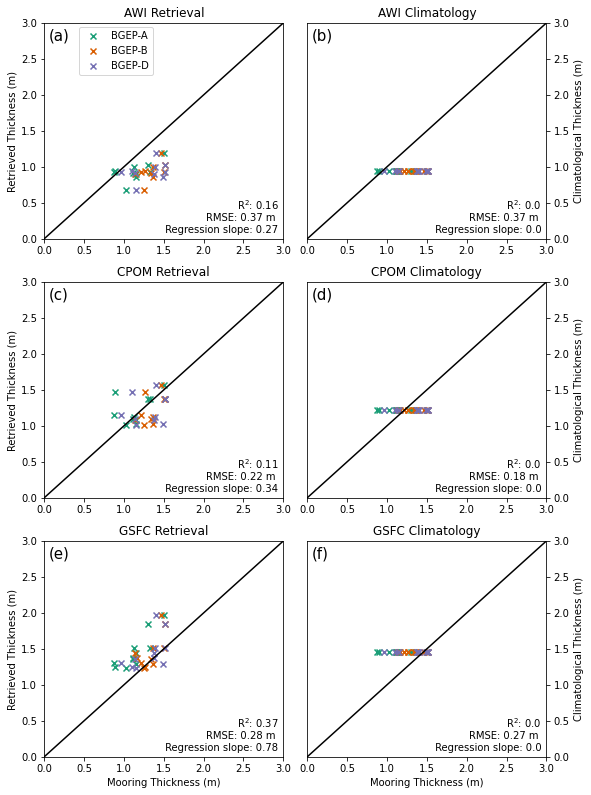


2


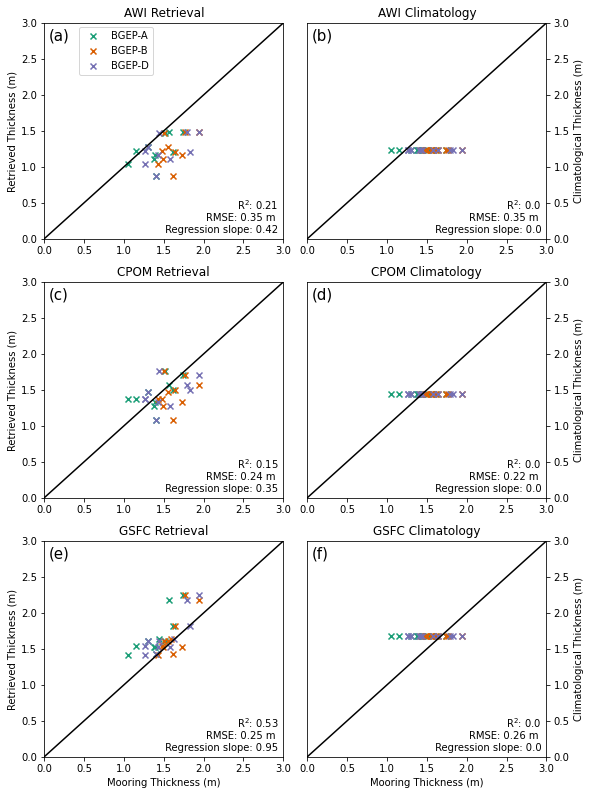


3


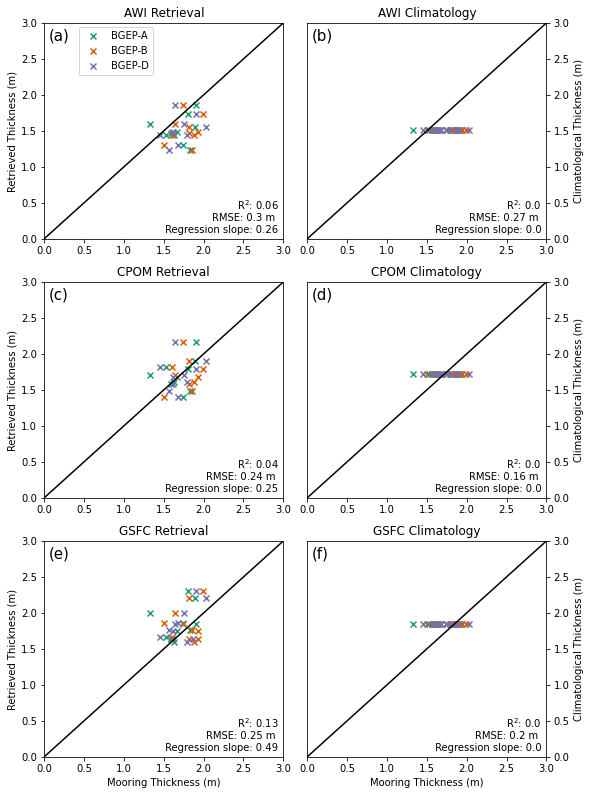


4


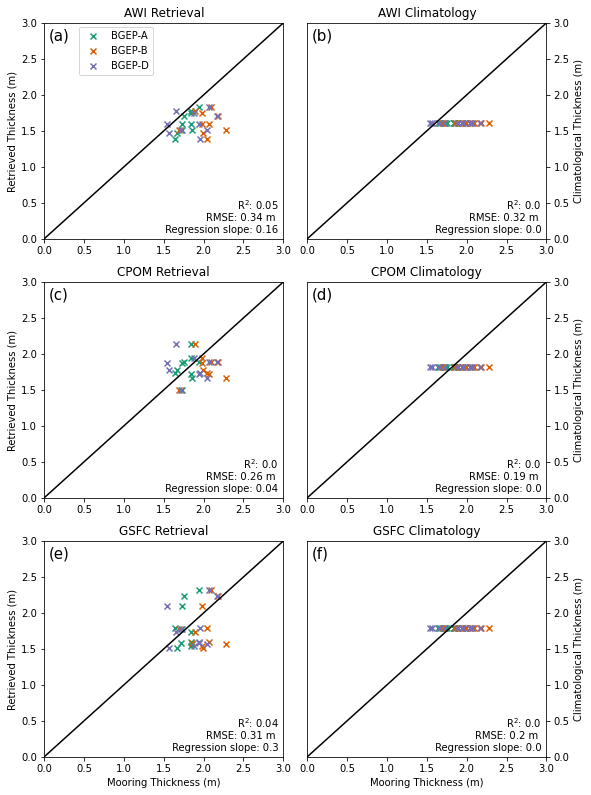

In [55]:
output = {}

for m in [10,11,12,1,2,3,4]:
    
    print()
    print(m)
    
    m = str(m).zfill(2)

    output[m] = {} 

    fs = 10

    for r in [100_000]:

        fig, axs = plt.subplots(3,2,figsize=(9,12*(9/8)))



        for var,label,(ax1,ax2) in zip([f'AWI_SIT_{r}',f'CPOM_SIT_{r}',f'NSIDC_SIT_{r}'],
                                ['AWI','CPOM','GSFC'],
                                axs):


            for mooring in ['a','b','d']:
                df = master_df[master_df['mooring']==mooring]

                df = df[df['month']==m]

                ax1.scatter(df['SIT'],df[var],color=colors[mooring],label=f'BGEP-{mooring.upper()}',marker='x')

                ax2.scatter(df['SIT'],df[f'{var}_c'],color=colors[mooring],label=f'BGEP-{mooring.upper()}',marker='x')

            for ax, c in zip((ax1,ax2),['','_c']):
                ax.set_ylim(-0.1,3)
                ax.set_xlim(-0.1,3)
                ax.plot([0,3],[0,3],color='k')    

                if 'GSFC' == label:
                    ax.set_xlabel('Mooring Thickness (m)',fontsize=10)


                df = master_df[['SIT',var+c,'month']].copy()

                df = df[df['month']==m]

                df.dropna(inplace=True)

                rmse = np.sqrt(np.nanmean(np.square(df[var+c]-df['SIT'])))

                lr = linregress(df['SIT'][~np.isnan(df[var+c])],df[var+c][~np.isnan(df[var+c])])
                corr = lr[2]

                r2 = np.round(corr**2,decimals=2)
                rmse_str = np.round(rmse,decimals=2)
                slope = np.round(lr[0],decimals=2)
                
                output[m][label+c] = f'{r2} / {rmse_str}'

                ax.annotate(f'R$^2$: {r2}\nRMSE: {rmse_str} m \n Regression slope: {slope}',xy=(0.98,0.02),
                            xycoords='axes fraction',va='bottom',ha='right',fontsize=fs)


            ax1.set_ylabel('Retrieved Thickness (m)',fontsize=fs)
            ax2.set_ylabel('Climatological Thickness (m)',fontsize=fs,labelpad=5)

            ax1.set_title(f'{label} Retrieval',fontsize=fs+2)
            ax2.set_title(f'{label} Climatology',fontsize=fs+2)

            ax2.yaxis.tick_right()
            ax2.yaxis.set_label_position('right')

            for ax in (ax1,ax2):
                ax.set_xlim(0,3)
                ax.set_ylim(0,3)

        axs.reshape(-1)[0].legend(bbox_to_anchor=(0.3,0.87),loc='center',fontsize=fs)

        fig.subplots_adjust(hspace=0.2,wspace=0.1)
        
        for letter, ax in zip(string.ascii_lowercase, axs.reshape(-1)):
            ax.annotate(f'({letter})',xycoords='axes fraction',fontsize=fs+5,xy=(0.02,0.92))

        plt.savefig(f'{datapath_out}supp_figs/climatology_{m}.png',bbox_inches='tight',dpi=500)

        plt.show()

### create supplementary table 1

In [56]:
df_ = pd.DataFrame(output).T
df_.to_csv(datapath+'skills.csv')